In [61]:
import dill
from sklearn import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import common_functions as cf
import importlib
importlib.reload(cf)

SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 3
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
NAME_PREFIX = lambda i: f"H1_5-s{i}-20231218-005"
MODEL_NAME_Z = "table_calibration/2x2_grid_subsampling_x3_08032024_schroef2"
MODEL_NAME_XY = "table_calibration/2x2_grid_xy_subsampling_x3_08032024_schroef2"

DATA_NAME = "table_calibration/2x2_grid_subsampling_x3_08032024_schroef2"

# Load the models
z_taxel_models = dill.load(open(os.path.join(os.getcwd(), f'../models/PolyLinear-Deg2/{MODEL_NAME_Z}'), 'rb'))
xy_taxel_models = dill.load(open(os.path.join(os.getcwd(), f'../models/PolyLinear-Deg2/{MODEL_NAME_XY}'), 'rb'))

print(z_taxel_models)
print(xy_taxel_models)

[Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))]),

In [62]:
# Load sensor data file including silicone
TFdata = cf.read_csv_file(f"../data/raw/TF/{DATA_NAME}.csv") 
sensordata = cf.read_csv_file(f'../data/raw/sensor/{DATA_NAME}.csv')

data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

# Unwrap sensor data
sensordata = cf.unwrap_data(sensordata, data_columns)

# Time sync
data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

# Remove mean of first 100 samples
data = cf.offset_data(data, data_columns, 100)

# Remove rows containing NaN values
data = data.dropna()

# Remove other columns
data = data.drop(columns=['t_robot', 'R_x', 'R_y', 'R_z'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59476 entries, 1 to 59476
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   59476 non-null  int64  
 1   t_wall  59476 non-null  float64
 2   X0      59476 non-null  float64
 3   Y0      59476 non-null  float64
 4   Z0      59476 non-null  float64
 5   X1      59476 non-null  float64
 6   Y1      59476 non-null  float64
 7   Z1      59476 non-null  float64
 8   X2      59476 non-null  float64
 9   Y2      59476 non-null  float64
 10  Z2      59476 non-null  float64
 11  X3      59476 non-null  float64
 12  Y3      59476 non-null  float64
 13  Z3      59476 non-null  float64
 14  F_x     59476 non-null  float64
 15  F_y     59476 non-null  float64
 16  F_z     59476 non-null  float64
 17  T_x     59476 non-null  float64
 18  T_y     59476 non-null  float64
 19  T_z     59476 non-null  float64
 20  X       59476 non-null  float64
 21  Y       59476 non-null  float64
 22

In [63]:
data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)

for i in range(ARRAY_SIZE):
    data[f'XY{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2)
    data[f'M{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2 + data[f'Z{i}']**2)

In [64]:
# Predict forces

for k in range(ARRAY_SIZE_SUB):
    
  # Predict
  X_xy = data[[f'XY{i}' for i in range(ARRAY_SIZE)]]
  X_z = data[[f'M{i}' for i in range(ARRAY_SIZE)]]
  Y_xy = xy_taxel_models[k].predict(X_xy.to_numpy())
  Y_z = z_taxel_models[k].predict(X_z.to_numpy())
  
  # add to PD
  data[f'F_xy{k}'] = Y_xy[:, 0]
  data[f'F_m{k}'] = Y_z[:, 0]

In [65]:
# Now make an animation for this
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import matplotlib.animation as animation

points = []

ARRAY_SUB_W = ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)
ARRAY_SUB_H = ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1)

for i in range(ARRAY_SUB_W):
  for j in range(ARRAY_SUB_H):
    points.append([i, j])

points = np.array(points)

nr_of_frames = len(data['F_z']) // 100

def animate(t):
  
    index = len(data['F_z']) // nr_of_frames * t
  
    print(f"Frame {t} / {nr_of_frames} (index {index})")
  
    # Clear
    plt.cla()
    
    # Plot boundaries of the subregions
    for i in range(ARRAY_SUB_W - 1):
      plt.plot([i + 0.5, i + 0.5], [-0.5, ARRAY_SUB_H - 0.5], 'k')
    for i in range(ARRAY_SUB_H - 1):
      plt.plot([-0.5, ARRAY_SUB_W - 0.5], [i + 0.5, i + 0.5], 'k')

    # Plot the "vector field"
    plt.quiver(points[:, 0], points[:, 1], data.iloc[index][[f'F_x{i}' for i in range(ARRAY_SIZE_SUB)]], data.iloc[index][[f'F_y{i}' for i in range(ARRAY_SIZE_SUB)]])

    # Set aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

matplotlib.animation.FuncAnimation(fig, animate, frames=nr_of_frames)

NameError: name 'matplotlib' is not defined

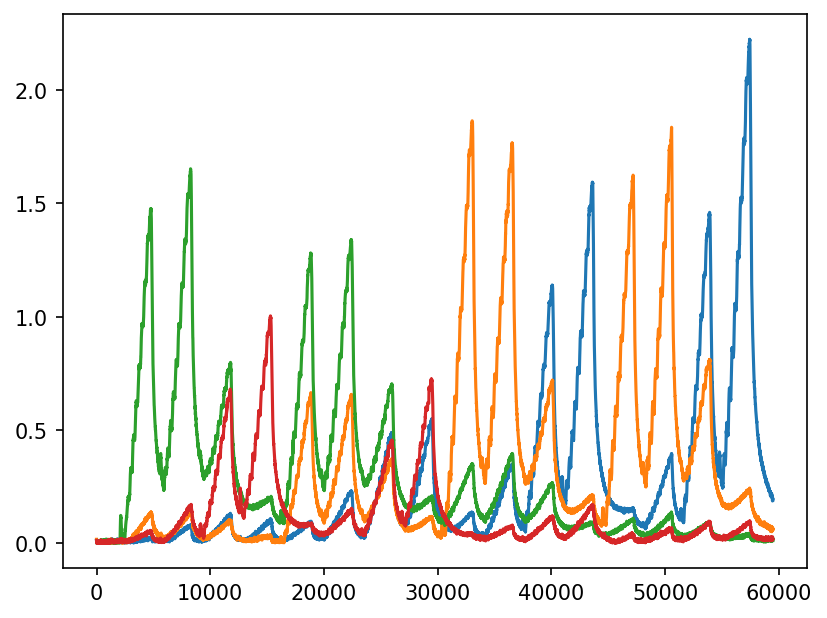

In [73]:
plt.plot(data['M0'])
plt.plot(data['M1'])
plt.plot(data['M2'])
plt.plot(data['M3'])
plt.show()

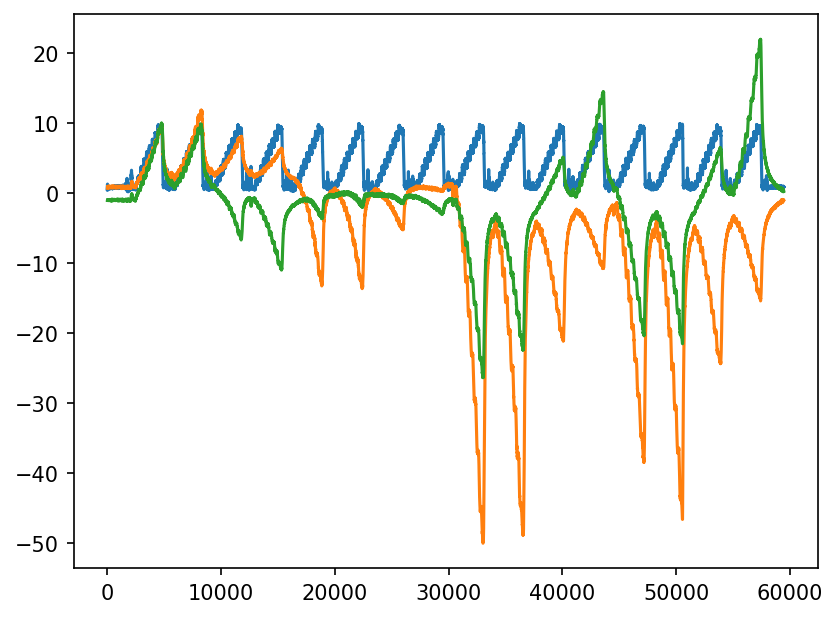

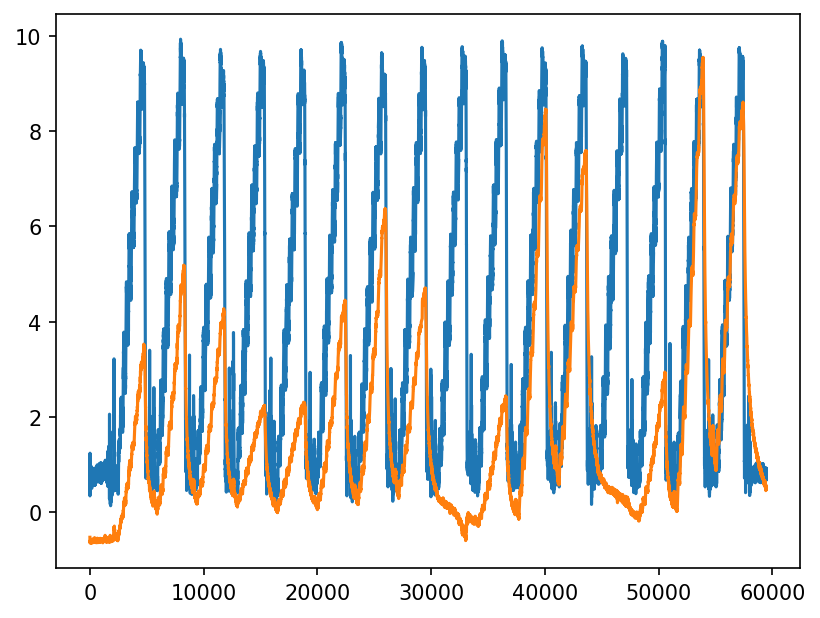

In [72]:

plt.plot(data['F_m'])

plt.plot(data['F_m0'])
plt.plot(data['F_m1'])
# plt.plot(data['F_z6'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z7'])
# plt.plot(data['F_z4'][:3000])
# plt.plot(data['F_z12'][:3000])
# plt.plot(data['F_z15'][:3000])

ys = [data[f'F_m{i}'] for i in range(ARRAY_SIZE_SUB)]
# plt.plot(np.sum(ys, axis=0))

# for i in range(ARRAY_SIZE_SUB):
#   plt.plot(ys[i])


plt.show()

plt.plot(data['F_m'])
plt.plot(np.sum(ys, axis=0) / 16)
plt.show()


In [68]:
# plt.plot(data['F_x'])
# plt.plot(data['F_x1'])
# plt.plot(data['F_x4'])
# plt.plot(data['F_x1'])

ys = [data[f'F_x{i}'] for i in range(ARRAY_SIZE_SUB)]

for i in range(ARRAY_SIZE_SUB):
  plt.plot(data['F_x'])
  plt.plot(ys[i])
  plt.show()

plt.plot(data['F_x'])
plt.plot(np.sum(ys, axis=0))
plt.show()

  

KeyError: 'F_x0'

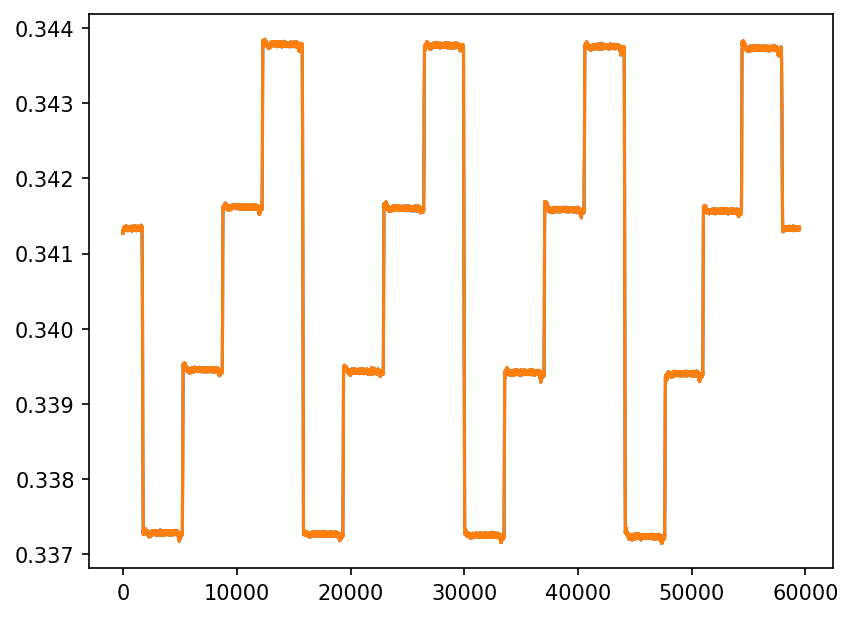

In [38]:
plt.plot(data['X'])
plt.show()